# Preliminary Predictive Modeling

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# import shap

from typing import List, Tuple, Union

import joblib

pd.set_option("display.max_columns", None)

In [2]:
from pipeline_to_sql import make_postgres_conn

## Functions

In [3]:
def transform_df(df: pd.DataFrame, columns2drop: List[str]) -> pd.DataFrame:
    df_ = df.copy()
    df_['death_yn'] = np.where(df_['death_yn']=='Yes', 1, 0)
    df_['low_income_score'] = df_['low_income_score'].replace(
        [0.0, 7.0, 15.0], ['Low', 'Medium', 'High'])
    df_['case_month'] = pd.to_datetime(df_['case_month']).dt.month_name()
    
    df_ = df_.loc[df_['current_status'] == 'Laboratory-confirmed case', :]
    df_.reset_index(drop=True, inplace=True)
    df_ = df_.drop(columns=columns_drop)
    return df_

In [4]:
def return_dummified_df(df: pd.DataFrame, dummy_columns: List[str], 
        drop_first: bool=False) -> pd.DataFrame:
    return pd.get_dummies(df, columns=dummy_columns, drop_first=drop_first)

In [5]:
def return_X_y_arrays(
        df:pd.DataFrame, y_column: str='death_yn'
        ) -> Tuple[np.ndarray, np.ndarray]:
    X = df.loc[:, df.columns != y_column]
    y = df.loc[:, y_column]
    return X.values, y.values

In [6]:
def get_sql_data(
        db_name: str, query: str, params: Union[int, None]=None) -> pd.DataFrame:
    conn = make_postgres_conn(db_name)
    
    if not params:
        df = pd.read_sql(query, conn)
    else:
        df = pd.read_sql(query, conn, params=params)
        
    conn.close()
    return df

In [7]:
def transform_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    df_ = df.copy()

    df_ = df_[~df_['res_county'].isna()]

    df_['age_group'] = df_['age_group'].fillna(df_['age_group'].mode()[0])
    df_['sex'] = df_['sex'].fillna(df_['sex'].mode()[0])
    df_['race'] = df_['race'].fillna(df_['race'].mode()[0])
    df_['ethnicity'] = df_['ethnicity'].fillna(df_['ethnicity'].mode()[0])
    df_['case_positive_specimen_interval'] = (
        df_['case_positive_specimen_interval'].fillna(
            df_['case_positive_specimen_interval'].median()))
    df_['case_onset_interval'] = (
        df_['case_onset_interval'].fillna(
            df_['case_onset_interval'].median()))
    
    return df_

## Loading data

In [8]:
no_nulls_query = """
            SELECT *
            FROM no_null_data;
            """

In [9]:
df = get_sql_data('covid_cases', no_nulls_query)

In [10]:
df.shape[0]

61650

## Data transformation

In [11]:
columns_drop = ['res_county', 'county_fips_code', 'process', 'current_status']
columns_dummy = ['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 
'exposure_yn', 'symptom_status', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 
'low_income_score']

In [12]:
df.shape[0]

61650

In [13]:
df = transform_df(df, columns2drop=columns_drop)

In [14]:
df.shape[0]

57515

## Dummy Classifier

In [15]:
data_rf = return_dummified_df(df, columns_dummy, drop_first=False)

In [16]:
X_rf, y_rf = return_X_y_arrays(data_rf)

In [17]:
y_rf

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2)

In [19]:
model_dum = DummyClassifier(strategy='stratified')
model_dum.fit(X_rf_train, y_rf_train)

DummyClassifier(strategy='stratified')

In [20]:
y_dum_pred = model_dum.predict(X_rf_test)

In [21]:
def print_recall_precision(y_test, y_pred):
    print(f'Recall:    {recall_score(y_test, y_pred):0.5f}')
    print(f'Precision: {precision_score(y_test, y_pred):0.5f}')

In [22]:
print_recall_precision(y_rf_test, y_dum_pred)

Recall:    0.02593
Precision: 0.02632


## Logistic Regression

In [23]:
data_log = return_dummified_df(df, columns_dummy, drop_first=True)

In [24]:
data_log.shape

(57515, 44)

In [25]:
X_log, y_log = return_X_y_arrays(data_log)

In [26]:
X_log[:, :2]

array([[3., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [27]:
scaler_mms = MinMaxScaler()
scaler_mms.fit(X_log[:, :2])

MinMaxScaler()

In [28]:
X_log[:, :2] = scaler_mms.transform(X_log[:, :2])

In [29]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.2)

In [30]:
model_log = LogisticRegression(solver='lbfgs', max_iter=500)

In [31]:
model_log.fit(X_log_train, y_log_train)

LogisticRegression(max_iter=500)

In [32]:
yhat_log = model_log.predict(X_log_test)

In [33]:
print_recall_precision(y_log_test, yhat_log)

Recall:    0.33829
Precision: 0.61905


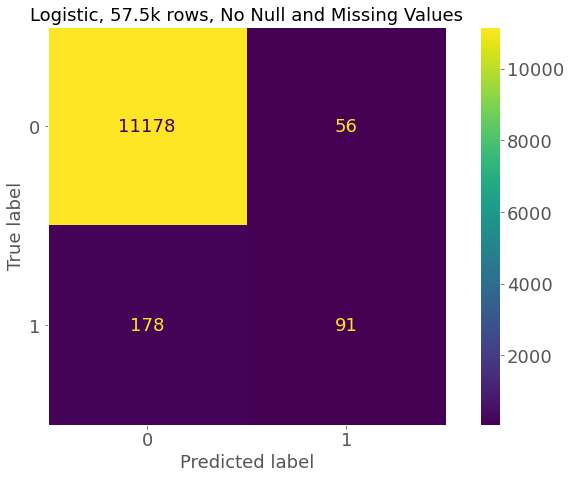

In [133]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_log = confusion_matrix(y_log_test, yhat_log, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=model_log.classes_)
# plt.rcParams.update({'font.size': 12})
plt.rc('font', size=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=18)
disp.plot(ax=ax)
plt.title('Logistic, 57.5k rows, No Null and Missing Values')
plt.tight_layout()
plt.grid(None)
plt.savefig('./../images/cm-logistic-no-null-no-missing.png');

## Random Forest

In [35]:
X_rf_train

array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.07692308, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.01437372, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [36]:
y_rf_train

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini')

In [38]:
model_rf.fit(X_rf_train, y_rf_train)

RandomForestClassifier()

In [39]:
yhat_rf = model_rf.predict(X_rf_test)

In [40]:
print_recall_precision(y_rf_test, yhat_rf)

Recall:    0.45926
Precision: 0.53219


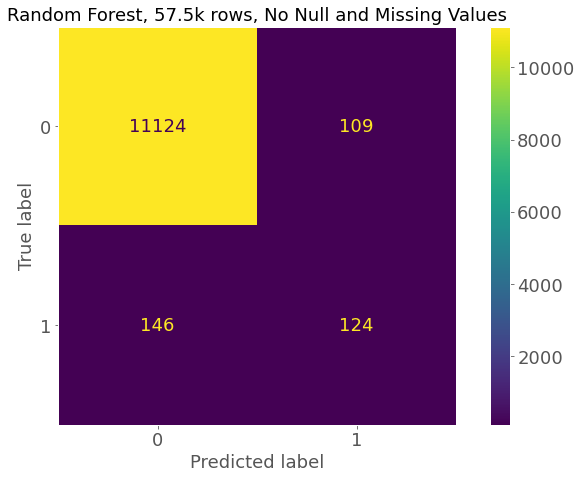

In [135]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_rf = confusion_matrix(y_rf_test, yhat_rf, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp.plot(ax=ax)
plt.title('Random Forest, 57.5k rows, No Null and Missing Values')
plt.grid(None)
plt.tight_layout()
plt.savefig('./../images/cm-rforest-no-null-no-missing.png');

### Feature importance: mean decrease impurity

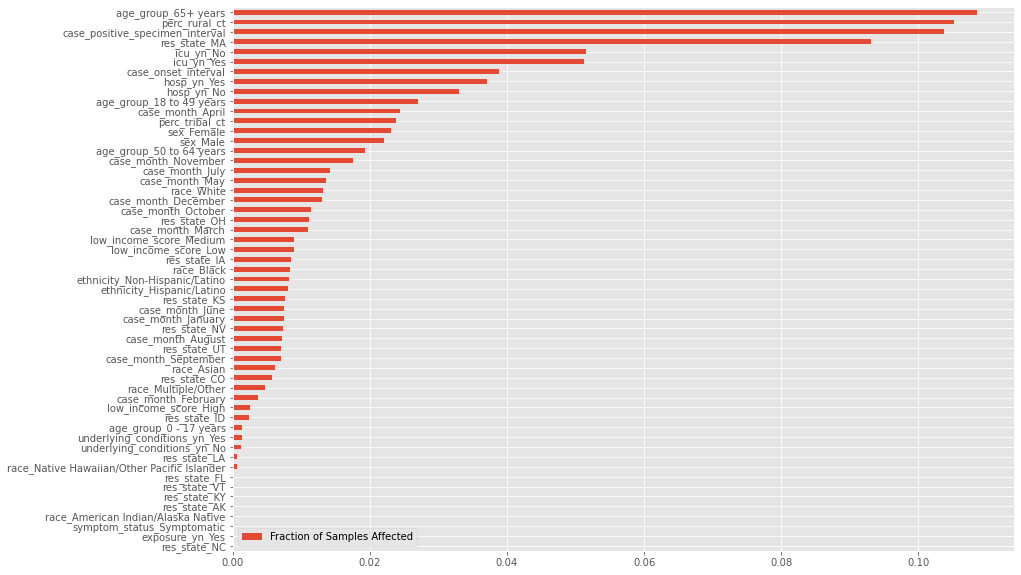

In [42]:
feat_scores = pd.DataFrame(
    {'Fraction of Samples Affected': model_rf.feature_importances_},
    index=data_rf.loc[:, data_rf.columns != 'death_yn'].columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(14,10));

### Trying shap for random forest model

In [43]:
# explainer = shap.TreeExplainer(model_rf)
# shap_values_rf = explainer.shap_values(X_rf_test)

In [44]:
# shap.summary_plot(shap_values=shap_values_rf,
#                  features=X_rf_train,
#                  features_names=data_rf.loc[:, data_rf.columns != 'death_yn'],
#                  plot_type='bar')

## Using 'some' dataset and imputing values

In [45]:
some_nulls_query = """
            SELECT *
            FROM some_null_data;
            """

In [46]:
df_some = get_sql_data('covid_cases', some_nulls_query)

In [47]:
df_some.head(2)

,case_month,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,low_income_score,perc_tribal_ct,perc_rural_ct
0,2020-05,IA,"POLK, IA",19153,18 to 49 years,Female,Missing,Hispanic/Latino,NaN,0.0,Missing,Yes,Laboratory-confirmed case,Symptomatic,No,No,No,Yes,0.0,0.0,0.020408
1,2020-04,PA,"LEHIGH, PA",42077,18 to 49 years,Female,Black,Hispanic/Latino,0.0,0.0,Missing,Yes,Laboratory-confirmed case,Symptomatic,No,No,No,Yes,0.0,0.0,0.013158


In [48]:
df_some.shape[0]

243238

In [49]:
df_some = transform_missing_data(df_some)

In [50]:
df_some.shape[0]

225099

In [51]:
df_some = transform_df(df_some, columns2drop=columns_drop)

In [52]:
df_some.shape[0]

203698

## Logistic with imputed values

In [53]:
data_some_log = return_dummified_df(df_some, columns_dummy, drop_first=True)

In [54]:
data_some_log.shape

(203698, 73)

In [55]:
data_some_log.columns

Index(['case_positive_specimen_interval', 'case_onset_interval', 'death_yn',
       'perc_tribal_ct', 'perc_rural_ct', 'case_month_August',
       'case_month_December', 'case_month_February', 'case_month_January',
       'case_month_July', 'case_month_June', 'case_month_March',
       'case_month_May', 'case_month_November', 'case_month_October',
       'case_month_September', 'res_state_AL', 'res_state_CA', 'res_state_CO',
       'res_state_DE', 'res_state_FL', 'res_state_IA', 'res_state_ID',
       'res_state_IL', 'res_state_KS', 'res_state_KY', 'res_state_LA',
       'res_state_MA', 'res_state_MD', 'res_state_MN', 'res_state_NC',
       'res_state_ND', 'res_state_NH', 'res_state_NJ', 'res_state_NM',
       'res_state_NV', 'res_state_NY', 'res_state_OH', 'res_state_PA',
       'res_state_RI', 'res_state_SC', 'res_state_TN', 'res_state_UT',
       'res_state_VA', 'res_state_VT', 'res_state_WA', 'res_state_WI',
       'age_group_18 to 49 years', 'age_group_50 to 64 years',
       'age

In [56]:
X_slog, y_slog = return_X_y_arrays(data_some_log)

In [57]:
scaler_mms = MinMaxScaler()
scaler_mms.fit(X_slog[:, :2])

MinMaxScaler()

In [58]:
X_slog[:, :2] = scaler_mms.transform(X_slog[:, :2])

In [59]:
X_slog_train, X_slog_test, y_slog_train, y_slog_test = train_test_split(X_slog, y_slog, test_size=0.2)

In [60]:
model_slog = LogisticRegression(solver='lbfgs', max_iter=500)

In [61]:
model_slog.fit(X_slog_train, y_slog_train)

LogisticRegression(max_iter=500)

In [62]:
yhat_slog = model_slog.predict(X_slog_test)

In [63]:
print_recall_precision(y_slog_test, yhat_slog)

Recall:    0.38373
Precision: 0.77747


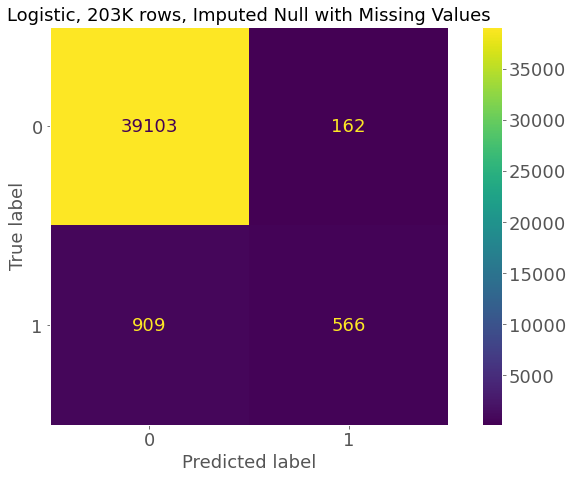

In [136]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_slog = confusion_matrix(y_slog_test, yhat_slog, labels=model_slog.classes_)
disp_slog = ConfusionMatrixDisplay(confusion_matrix=cm_slog, display_labels=model_slog.classes_)
disp_slog.plot(ax=ax)
plt.title('Logistic, 203K rows, Imputed Null with Missing Values')
plt.grid(None)
plt.tight_layout()
plt.savefig('./../images/cm-logistic-imputed-null-keep-missing.png');

## Random forest with imputed values

In [65]:
data_srf = return_dummified_df(df_some, columns_dummy, drop_first=False)

In [66]:
X_srf, y_srf = return_X_y_arrays(data_srf)

In [67]:
X_srf_train, X_srf_test, y_srf_train, y_srf_test = train_test_split(X_srf, y_srf, test_size=0.2)

In [68]:
X_srf_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.01437372, ..., 0.        , 1.        ,
        0.        ]])

In [69]:
y_srf_train

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
model_srf = RandomForestClassifier(n_estimators=100, criterion='gini')

In [71]:
model_srf.fit(X_srf_train, y_srf_train)

RandomForestClassifier()

In [72]:
yhat_srf = model_srf.predict(X_srf_test)

In [73]:
print_recall_precision(y_srf_test, yhat_srf)

Recall:    0.50834
Precision: 0.69210


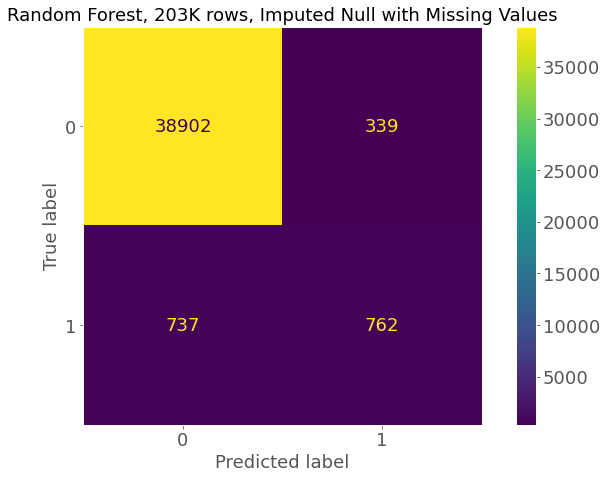

In [137]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_srf = confusion_matrix(y_srf_test, yhat_srf, labels=model_srf.classes_)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_srf, display_labels=model_srf.classes_)
disp_s.plot(ax=ax)
plt.title('Random Forest, 203K rows, Imputed Null with Missing Values')
plt.grid(None)
plt.tight_layout()
plt.savefig('./../images/cm-rforest-imputed-null-keep-missing.png');

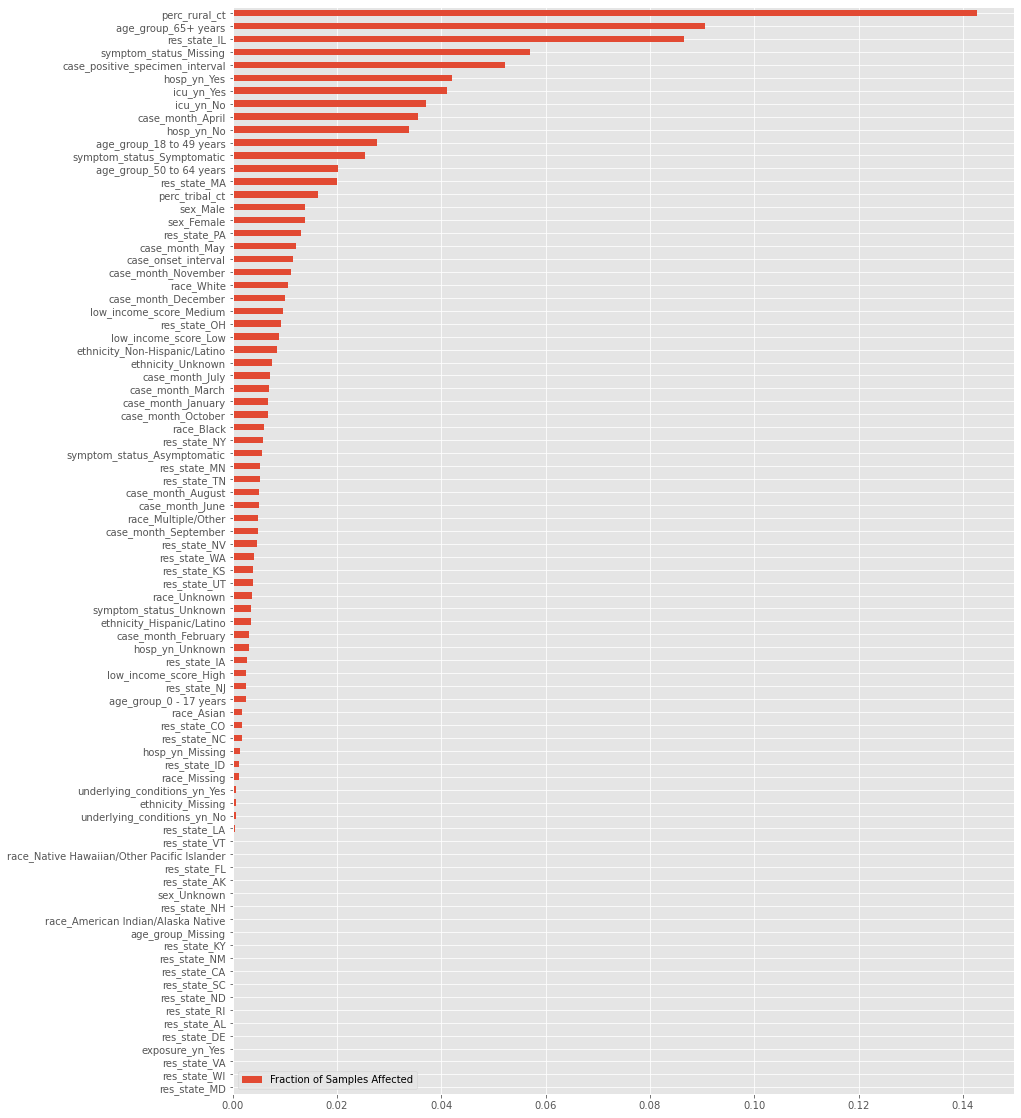

In [75]:
feat_scores_s = pd.DataFrame(
    {'Fraction of Samples Affected': model_srf.feature_importances_},
    index=data_srf.loc[:, data_srf.columns != 'death_yn'].columns)
feat_scores_s = feat_scores_s.sort_values(by='Fraction of Samples Affected')
feat_scores_s.plot(kind='barh', figsize=(14,20));

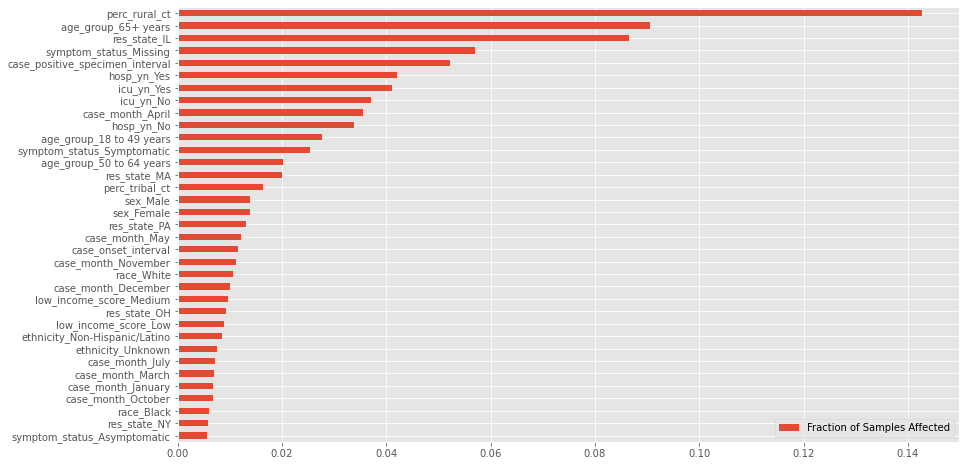

In [76]:
test = feat_scores_s.sort_values(by='Fraction of Samples Affected', ascending=False)[:35]
test.sort_values(by='Fraction of Samples Affected').plot(kind='barh', figsize=(14,8));

## Using 'all' dataset and imputing values
Removing high null/missing columns

In [77]:
num_rows = 3_000_000

In [78]:
num_rows_string = f'{num_rows/1_000_000}M'

In [79]:
all_query = """
            SELECT *
            FROM all_case_data
            LIMIT %s;
            """

In [80]:
df_all = get_sql_data('covid_cases', all_query, params=[num_rows])

In [81]:
df_all.shape[0]

3000000

In [82]:
df_all.head(2)

,case_month,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,low_income_score,perc_tribal_ct,perc_rural_ct
0,2021-05,CA,None,None,None,None,None,None,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,No,Missing,No,None,NaN,NaN,NaN
1,2021-05,CA,None,None,None,None,None,None,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,No,Missing,No,None,NaN,NaN,NaN


In [83]:
df_all = transform_missing_data(df_all)

In [84]:
df_all.shape[0]

2982724

In [85]:
df_all = transform_df(df_all, columns2drop=columns_drop)

In [86]:
df_all.shape[0]

2616996

In [87]:
df_all = df_all.drop(
    columns=['underlying_conditions_yn', 'icu_yn', 'exposure_yn', 
        'case_positive_specimen_interval'])

In [88]:
columns_dummy_all = ['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 'symptom_status', 'hosp_yn', 'low_income_score']

## Logistic with all dataset

In [89]:
data_all_log = return_dummified_df(df_all, columns_dummy_all, drop_first=True)

In [90]:
data_all_log.shape

(2616996, 81)

In [91]:
data_all_log.columns

Index(['case_onset_interval', 'death_yn', 'perc_tribal_ct', 'perc_rural_ct',
       'case_month_August', 'case_month_December', 'case_month_February',
       'case_month_January', 'case_month_July', 'case_month_June',
       'case_month_March', 'case_month_May', 'case_month_November',
       'case_month_October', 'case_month_September', 'res_state_AL',
       'res_state_AR', 'res_state_AZ', 'res_state_CA', 'res_state_CO',
       'res_state_CT', 'res_state_FL', 'res_state_GA', 'res_state_IA',
       'res_state_ID', 'res_state_IL', 'res_state_IN', 'res_state_KS',
       'res_state_KY', 'res_state_LA', 'res_state_MA', 'res_state_MD',
       'res_state_ME', 'res_state_MI', 'res_state_MN', 'res_state_MS',
       'res_state_MT', 'res_state_NC', 'res_state_ND', 'res_state_NH',
       'res_state_NJ', 'res_state_NM', 'res_state_NV', 'res_state_NY',
       'res_state_OH', 'res_state_OK', 'res_state_OR', 'res_state_PA',
       'res_state_RI', 'res_state_SC', 'res_state_TN', 'res_state_UT',
      

In [92]:
X_alog, y_alog = return_X_y_arrays(data_all_log)

In [93]:
scaler_mms = MinMaxScaler()
scaler_mms.fit(X_alog[:, :2])

MinMaxScaler()

In [94]:
X_alog[:, :2] = scaler_mms.transform(X_alog[:, :2])

In [95]:
X_alog_train, X_alog_test, y_alog_train, y_alog_test = train_test_split(X_alog, y_alog, test_size=0.2)

In [96]:
model_alog = LogisticRegression(solver='lbfgs', max_iter=500)

In [97]:
model_alog.fit(X_alog_train, y_alog_train)

LogisticRegression(max_iter=500)

In [98]:
yhat_alog = model_alog.predict(X_alog_test)

In [99]:
print_recall_precision(y_alog_test, yhat_alog)

Recall:    0.24600
Precision: 0.70678


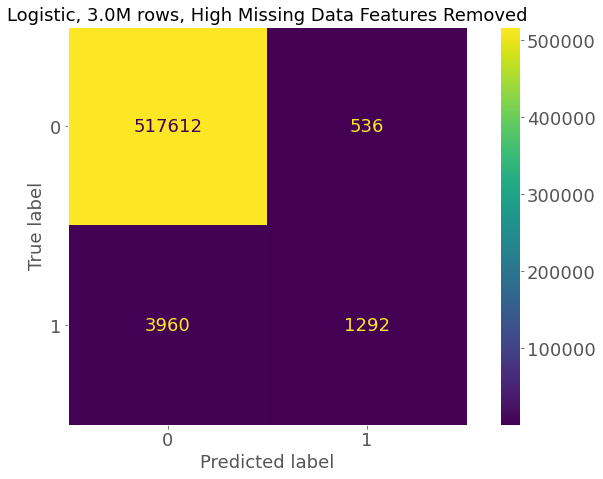

In [138]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_alog = confusion_matrix(y_alog_test, yhat_alog, labels=model_alog.classes_)
disp_alog = ConfusionMatrixDisplay(confusion_matrix=cm_alog, display_labels=model_alog.classes_)
disp_alog.plot(ax=ax)
plt.title(f'Logistic, {num_rows_string} rows, High Missing Data Features Removed')
plt.grid(None)
plt.tight_layout()
plt.savefig('./../images/cm-logistic-high-missing-features-removed.png');

## Random forest with all dataset

In [101]:
data_arf = return_dummified_df(df_all, columns_dummy_all, drop_first=False)

In [102]:
X_arf, y_arf = return_X_y_arrays(data_arf)

In [103]:
X_arf_train, X_arf_test, y_arf_train, y_arf_test = train_test_split(X_arf, y_arf, test_size=0.2)

In [104]:
model_arf = RandomForestClassifier(n_estimators=100, criterion='gini')

In [105]:
model_arf.fit(X_arf_train, y_arf_train)

RandomForestClassifier()

In [106]:
yhat_arf = model_arf.predict(X_arf_test)

In [107]:
print_recall_precision(y_arf_test, yhat_arf)

Recall:    0.53652
Precision: 0.76024


In [108]:
# joblib.dump(model_arf, './../model/random-forest-high-null-features-removed.sav')

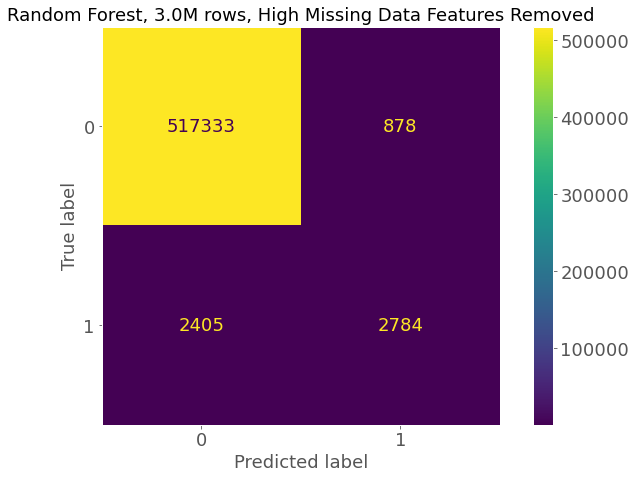

In [139]:
fig, ax = plt.subplots(figsize=(10, 7))
cm_arf = confusion_matrix(y_arf_test, yhat_arf, labels=model_arf.classes_)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_arf, display_labels=model_arf.classes_)
disp_a.plot(ax=ax)
plt.title(f'Random Forest, {num_rows_string} rows, High Missing Data Features Removed')
plt.grid(None)
plt.tight_layout()
plt.savefig('./../images/cm-rforest-high-missing-features-removed.png');

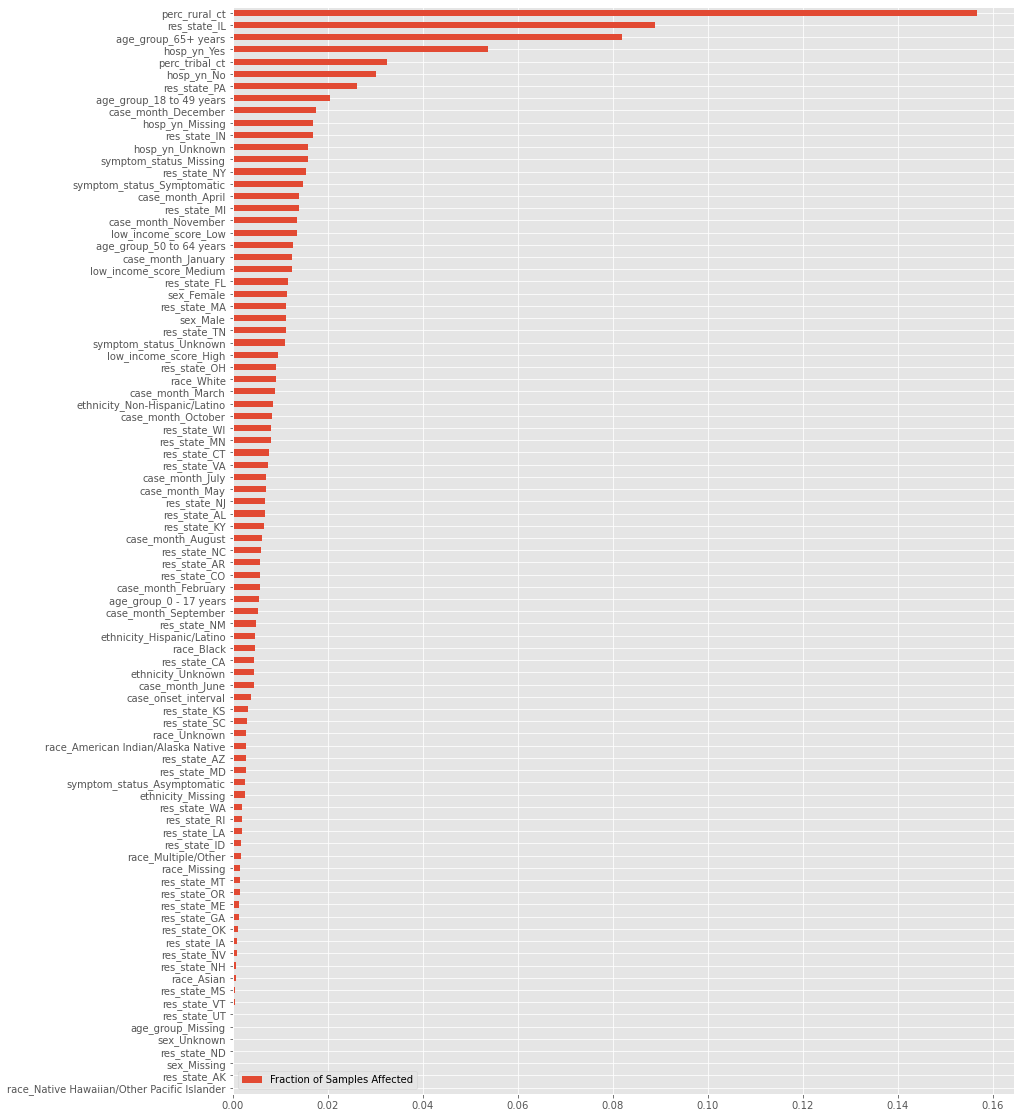

In [110]:
feat_scores_a = pd.DataFrame(
    {'Fraction of Samples Affected': model_arf.feature_importances_},
    index=data_arf.loc[:, data_arf.columns != 'death_yn'].columns)
feat_scores_a = feat_scores_a.sort_values(by='Fraction of Samples Affected')
feat_scores_a.plot(kind='barh', figsize=(14,20));

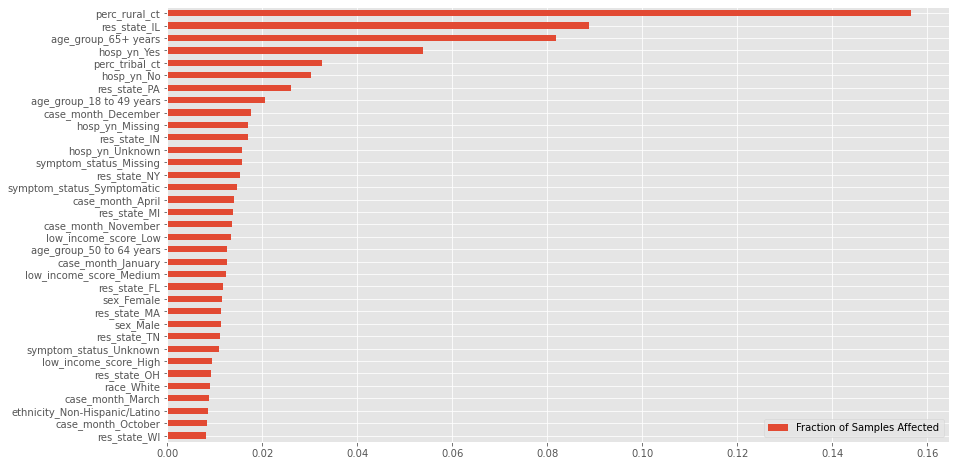

In [111]:
test_a = feat_scores_a.sort_values(by='Fraction of Samples Affected', ascending=False)[:35]
test_a.sort_values(by='Fraction of Samples Affected').plot(kind='barh', figsize=(14,8));

In [112]:
feat_scores_a.reset_index()['index'][feat_scores_a.reset_index()['index'].str.contains('res_state')].reset_index()

,level_0,index
0,1,res_state_AK
1,3,res_state_ND
2,6,res_state_UT
3,7,res_state_VT
4,8,res_state_MS
5,10,res_state_NH
6,11,res_state_NV
7,12,res_state_IA
8,13,res_state_OK
9,14,res_state_GA
